In [9]:
!pip install opencv-python numpy matplotlib

In [205]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [206]:
# === Load and Resize Image ===
def load_image(path):
    """
    Loads a color image and resizes it to 256x256.
    Also converts it to grayscale for compression techniques that require it.
    """
    color_img = cv2.imread(path, cv2.IMREAD_COLOR)  # Load image in BGR (color)
    color_img = cv2.resize(color_img, (256, 256))   # Resize to standard size
    gray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    return color_img, gray_img

In [207]:
# === Bit-plane Slicing ===
def bit_plane_slicing(img):
    """
    Splits an 8-bit grayscale image into 8 binary planes (bit planes).
    Each bit plane contains the bits at a specific position (0 to 7).
    """
    planes = []
    for i in range(8):
        plane = (img >> i) & 1  # Extract bit at position i
        planes.append(plane.astype(np.uint8))
    return planes

In [208]:
# === Reconstruct Image from Selected Bit Planes ===
def reconstruct_from_bit_planes(planes, start_bit=6):
    """
    Reconstructs image using only higher-order bits (e.g., bits 6 and 7).
    This provides a compressed but visually similar version of the image.
    """
    reconstructed = np.zeros_like(planes[0], dtype=np.uint8)
    for i in range(start_bit, 8):  # Use only MSBs (e.g., 6 and 7)
        reconstructed |= (planes[i] << i)
    return reconstructed

In [209]:
# === JPEG Compression Using OpenCV ===
def jpeg_compress_decompress(img, quality=50):
    """
    Compresses a grayscale image using JPEG (lossy) compression with specified quality.
    Decompresses it back to image form and calculates compressed size in bits.
    """
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]  # JPEG quality (1-100)
    result, encimg = cv2.imencode('.jpg', img, encode_param)  # Encode to JPEG format
    decimg = cv2.imdecode(encimg, cv2.IMREAD_GRAYSCALE)       # Decode back to image
    compressed_bits = len(encimg) * 8  # Calculate size in bits
    return decimg, compressed_bits

In [210]:
# === Compression Ratio Calculation ===
def calculate_compression_ratio(original_img, compressed_bits):
    """
    Calculates compression ratio as:
        Original size in bits / Compressed size in bits
    """
    original_bits = original_img.size * 8  # 8 bits per pixel for grayscale
    if compressed_bits == 0:
        return float('inf')  # Avoid divide-by-zero
    return original_bits / compressed_bits

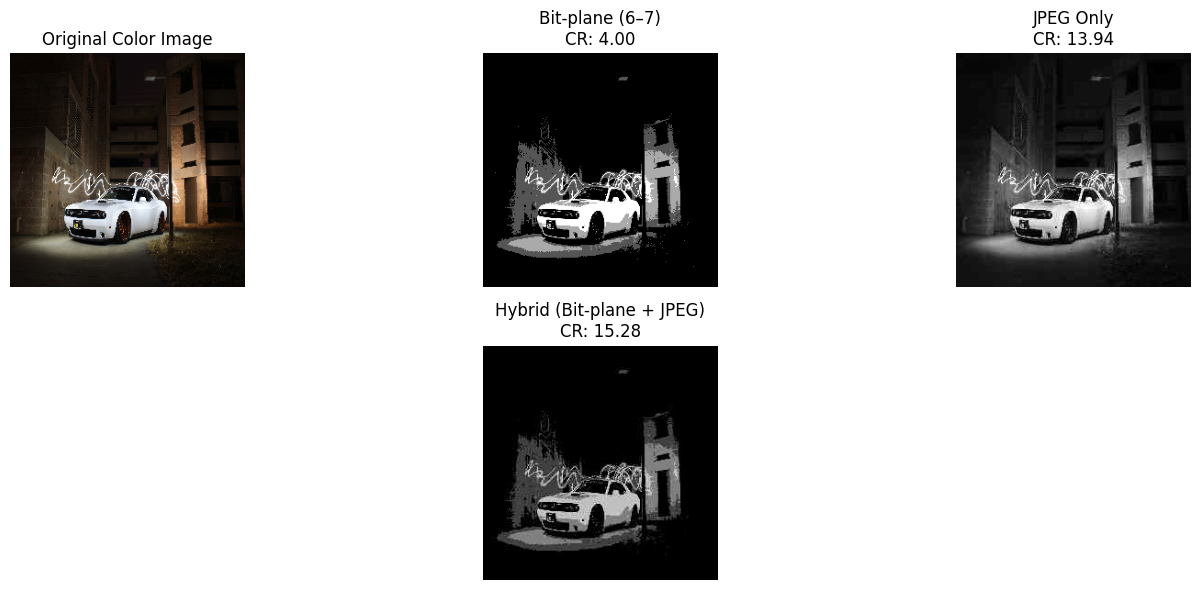

In [211]:
# === Main Program ===
if __name__ == "__main__":
    # === Load Color and Grayscale Versions ===
    color_img, gray_img = load_image("/content/pexels-cesar-perez-733745.jpg")  # Replace with your own path

    # === 1. Bit-plane Compression ===
    planes = bit_plane_slicing(gray_img)  # Split image into 8 bit-planes
    bitplane_img = reconstruct_from_bit_planes(planes, start_bit=6)  # Use MSB bits only (6 & 7)
    bitplane_bits = gray_img.size * 2  # Only storing 2 bits per pixel (instead of 8)
    bitplane_cr = calculate_compression_ratio(gray_img, bitplane_bits)  # Compute CR

    # === 2. JPEG Compression ===
    jpeg_img, jpeg_bits = jpeg_compress_decompress(gray_img, quality=30)  # Compress using JPEG
    jpeg_cr = calculate_compression_ratio(gray_img, jpeg_bits)  # Compute CR

    # === 3. Hybrid Compression (Bit-plane + JPEG) ===
    # Apply JPEG compression on the image reconstructed from MSB bitplanes
    hybrid_img, hybrid_bits = jpeg_compress_decompress(bitplane_img, quality=30)
    hybrid_cr = calculate_compression_ratio(gray_img, hybrid_bits)  # Compute CR

    # === Display Original and Compressed Images ===
    plt.figure(figsize=(15, 6))

    # Original Color Image
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB for display
    plt.title("Original Color Image")
    plt.axis('off')

    # Bit-plane Compressed Image
    plt.subplot(2, 3, 2)
    plt.imshow(bitplane_img, cmap='gray')
    plt.title(f"Bit-plane (6–7)\nCR: {bitplane_cr:.2f}")
    plt.axis('off')

    # JPEG Compressed Image
    plt.subplot(2, 3, 3)
    plt.imshow(jpeg_img, cmap='gray')
    plt.title(f"JPEG Only\nCR: {jpeg_cr:.2f}")
    plt.axis('off')

    # Hybrid Compressed Image
    plt.subplot(2, 3, 5)
    plt.imshow(hybrid_img, cmap='gray')
    plt.title(f"Hybrid (Bit-plane + JPEG)\nCR: {hybrid_cr:.2f}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()